# Augmentation on images

In [3]:
!pip install mycolorpy --quiet
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/M_DV_V2022'
/content/gdrive/MyDrive/M_DV_V2022


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Sobel, Laplacian, watershed
import cv2 as cv
import seaborn as sns

import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input

from unet_detection.models.vanilla_unet import vanilla_unet

## Load data

In [5]:
X_train = np.load("data/spec_lib/X_data.npy") 
#X_70_train = np.load("data/spec_lib/X_70_data.npy")
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
#X_70_val = np.load("data/spec_lib/X_70_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
#X_70_test = np.load("data/spec_lib/X_70_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [6]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [7]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 6)
(20, 128, 128, 6)
(50, 128, 128, 6)


## Augmentation on data

In [ ]:
X_train[X_train<0] = 0
X_train[X_train>10000] = 10000

X_val[X_val<0] = 0
X_val[X_val>10000] = 10000

In [ ]:
def augment_brightness(X,y, n=10):
    datagen = ImageDataGenerator(horizontal_flip=True)
    # Xshape = (n, x,y,c)
    brigthness = [0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.5]
    list_of_indx = np.linspace(0, X.shape[0]-1, X.shape[0], dtype=int)

    indx = np.random.choice(list_of_indx, size=n, replace=False)
    brigt = np.random.choice(brigthness, size=n)
    print(indx, brigt)
    img = []
    img_y = []

    for i,b in zip(indx, brigt):
      temp_img = datagen.apply_transform(X[i], {"flip_horizontal":True})
      img.append(temp_img * b)
      img_y.append(datagen.apply_transform(y[i], {"flip_horizontal":True}))

    img = np.array(img)
    img_y = np.array(img_y)
    return img, img_y

In [ ]:
X_train_aug, y_train_aug = augment_brightness(X_train,y_train, n=75)

In [ ]:
plt.imshow(np.stack([X_train_aug[0,:,:,81],
                     X_train_aug[0,:,:,46],
                     X_train_aug[0,:,:,21]],axis=2)/2500)
plt.title("Augmentet")
plt.show()

plt.imshow(y_train_aug[0].argmax(axis=2))
plt.title("y aug")
plt.show()

In [ ]:
i = 46
plt.imshow(np.stack([X_train[i,:,:,81],
                     X_train[i,:,:,46],
                     X_train[i,:,:,21]],axis=2)/2500)
plt.title("Original")
plt.show()

plt.imshow(y_train[i].argmax(axis=2))
plt.title("y")
plt.show()

In [ ]:
y_train_aug.shape

In [ ]:
X_train = np.append(X_train, X_train_aug, axis=0)
y_train = np.append(y_train, y_train_aug, axis=0)

## Weighten the y data

In [ ]:
X.shape

In [34]:
sample_weigths = np.ones((y_train.shape[0], y_train.shape[1], y_train.shape[2],1))

#y_test
#sample_weigths[:,:,:,1] += 10

In [35]:
unik = np.unique(y_train.argmax(axis=3), return_counts=True)

In [36]:
unik

(array([0, 1, 2, 3, 4, 5]),
 array([2195124,    8392,  184035,   18784,   26599,   24666]))

In [37]:
y = y_train.argmax(axis=3)

In [38]:
for c,u in zip(unik[0], unik[1]):
  #print(c)
  print(1/(u/sum(unik[1])))
  sample_weigths[y[:,:,:] == c] = 1/(u/sum(unik[1]))

#sum([2195124,    8392,  184035,   18784,   26599,   24666])

1.1195722883991974
292.85033365109626
13.353981579590839
130.83475298126064
92.3944509192075
99.63512527365604


In [ ]:
y.shape

In [ ]:
sample_weigths.shape

## Set up unet and train

In [27]:
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=6, last_activation='softmax')

model.compile(optimizer='adam',
              loss='categorical_crossentropy')

In [28]:
h = model.fit(X_train,
              y_train, 
              validation_data=(X_val,y_val), 
              batch_size=32,
              epochs=180,
              verbose=1,
              sample_weight = sample_weigths)

Epoch 1/180
5/5 [==============================] - 6s 511ms/step - loss: 11.8612 - val_loss: 12.8743
Epoch 2/180
5/5 [==============================] - 2s 348ms/step - loss: 10.5224 - val_loss: 103.2599
Epoch 3/180
5/5 [==============================] - 2s 344ms/step - loss: 9.4557 - val_loss: 304.7865
Epoch 4/180
5/5 [==============================] - 2s 346ms/step - loss: 8.6564 - val_loss: 366.7353
Epoch 5/180
5/5 [==============================] - 2s 350ms/step - loss: 8.0231 - val_loss: 307.1854
Epoch 6/180
5/5 [==============================] - 2s 350ms/step - loss: 7.4282 - val_loss: 197.4891
Epoch 7/180
5/5 [==============================] - 2s 349ms/step - loss: 7.0586 - val_loss: 112.0480
Epoch 8/180
5/5 [==============================] - 2s 352ms/step - loss: 6.8869 - val_loss: 62.5543
Epoch 9/180
5/5 [==============================] - 2s 337ms/step - loss: 6.6583 - val_loss: 38.8854
Epoch 10/180
5/5 [==============================] - 2s 347ms/step - loss: 6.3857 - val_loss:

Text(0, 0.5, 'loss')

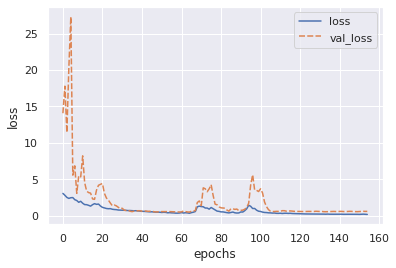

In [29]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][25:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")

## Validate data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


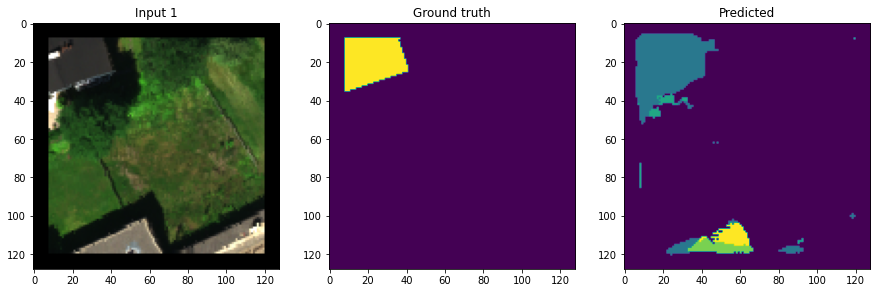

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


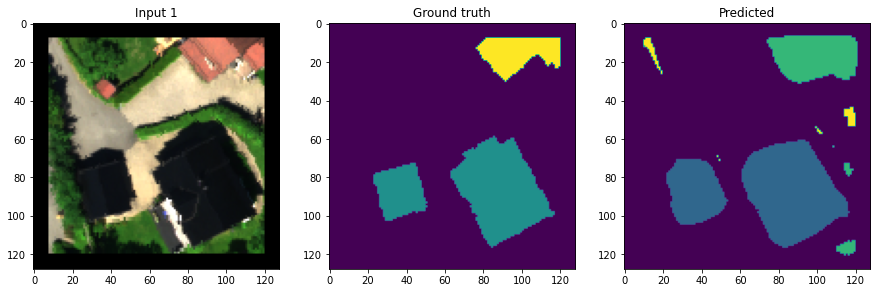

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


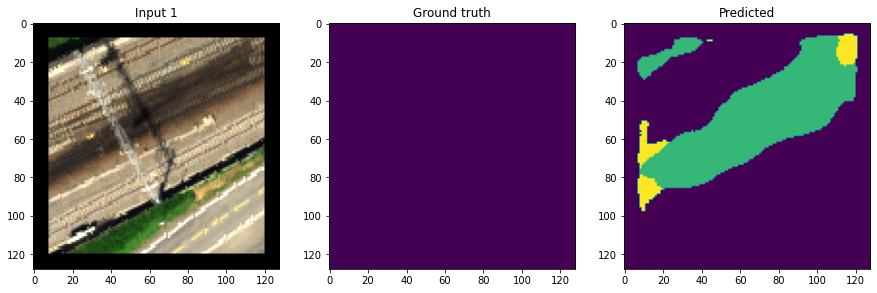

In [19]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


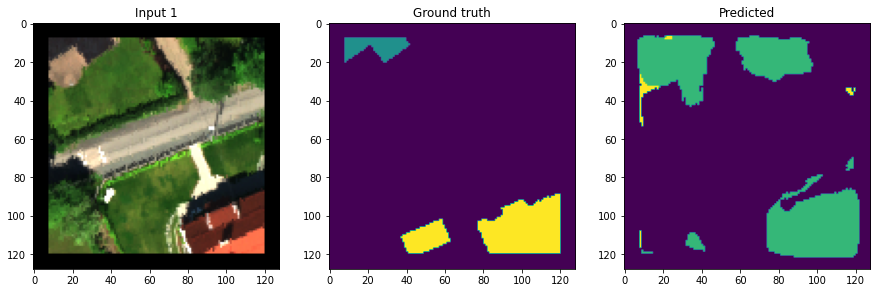

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


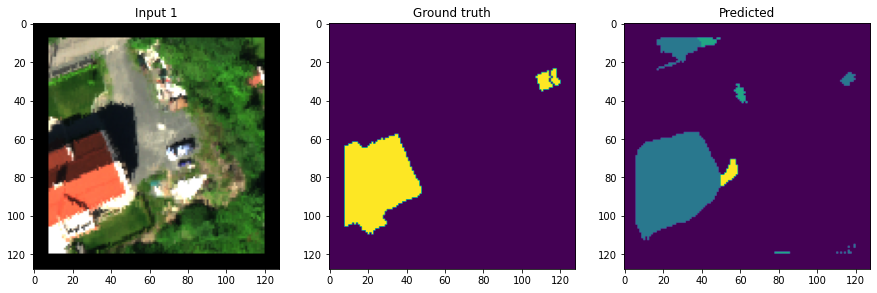

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


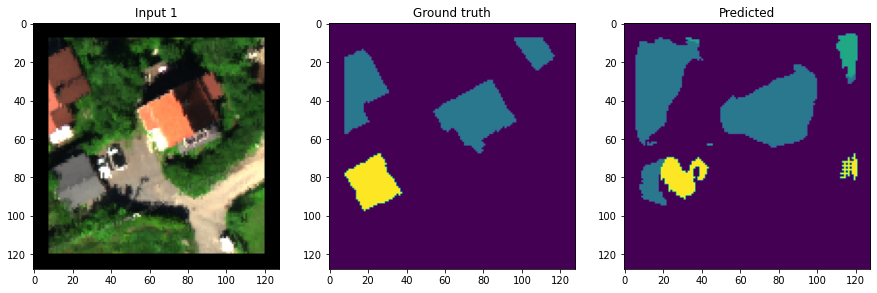

In [21]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_test.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
                        X_test[x:x+1][0][:,:,46],
                        X_test[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_test[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_test[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


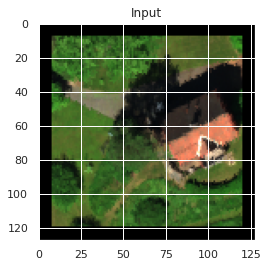

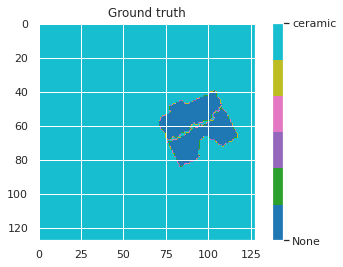

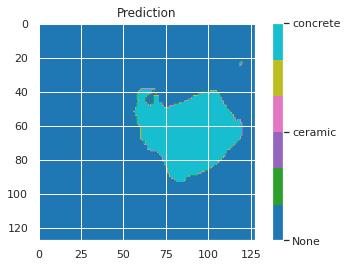

In [30]:
n = 23

plt.imshow(np.dstack([X_test[n,:,:,76], X_test[n,:,:,46], X_test[n,:,:,21]])/2500)
plt.title("Input")
plt.show()

ticks = ["None"]
ticks.extend(['ceramic',
 'concrete',
 'eternit',
 'metal',
 'tar roofing paper'])

colors=mcp.gen_color(cmap="tab10",n=6)
colormap = ListedColormap(colors)

plt.imshow(y_test[n:n+1,:,:,0][0], cmap=colormap)
#cbar = plt.colorbar()
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Ground truth")
plt.show()


pred = model.predict(X_test[n:n+1]).argmax(axis=3)[0]
plt.imshow(pred, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Prediction")
plt.show()

In [ ]:
np.min(y_test[1])

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(pred)

# MEtrcis

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_tot = model.predict(X_test)

[Text(0, 0, 'None'),
 Text(0, 0, 'ceramic'),
 Text(0, 0, 'concrete'),
 Text(0, 0, 'eternit'),
 Text(0, 0, 'metal'),
 Text(0, 0, 'tar roofing paper')]

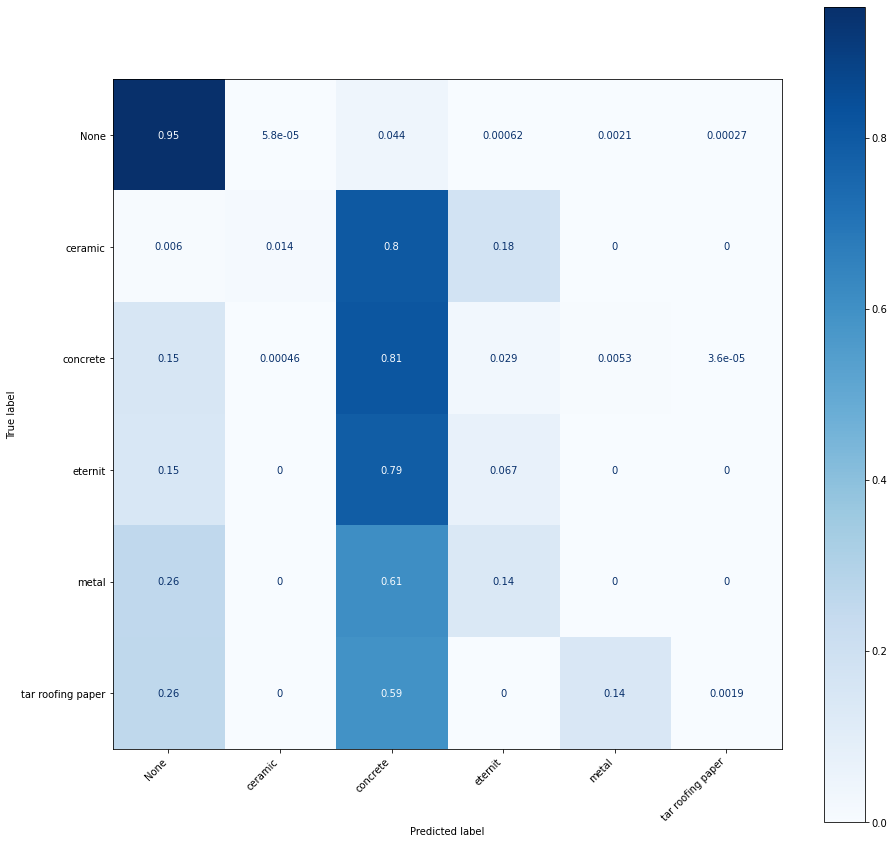

In [32]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))

ticks = np.array(ticks)
true = ticks[y_test.argmax(axis=3).flatten()]
pre = ticks[pred_tot.argmax(axis=3).flatten()]

true_ = true[true != "None"]
pre_ = pre[pre != "Noen"]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")

In [33]:
from sklearn.metrics import classification_report
print(classification_report(true,pre,target_names=ticks))

                   precision    recall  f1-score   support

             None       0.99      0.95      0.97    776182
          ceramic       0.46      0.01      0.03      3662
         concrete       0.34      0.81      0.48     28048
          eternit       0.16      0.07      0.09      6260
            metal       0.00      0.00      0.00      1920
tar roofing paper       0.03      0.00      0.00      3128

         accuracy                           0.93    819200
        macro avg       0.33      0.31      0.26    819200
     weighted avg       0.95      0.93      0.94    819200

